# SV model with variational particle filter

In [1]:
import matplotlib.pyplot as plt
import torch
import pandas as pd
pd.set_option('precision', 4)

import ptvi

dtype = torch.float64
nparticles = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
data_seed, algo_seed = 1234, 1234
params = dict(a=1., b=0., c=.95)
T = 100

In [3]:
model = ptvi.FilteredSVModelDualOpt(
    input_length=T, num_particles=nparticles, resample=True, dtype=dtype, device=device)
model

Stochastic volatility model for dual optimization of model and proposal:
	x_t = exp(a * z_t/2) ε_t      t=1, …, 100
	z_t = b + c * z_{t-1} + ν_t,  t=2, …, 100
	z_1 = b + 1/√(1 - c^2) ν_1
	where ε_t, ν_t ~ Ν(0,1)

Particle filter with 20 particles, AR(1) proposal:
	z_t = d + e * z_{t-1} + η_t,  t=2, …, 100
	z_1 = d + 1/√(1 - e^2) η_1
	where η_t ~ Ν(0,1)

In [4]:
torch.manual_seed(data_seed)
y, z_true = model.simulate(**params)

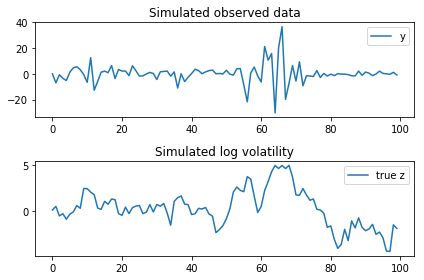

In [5]:
plt.subplot(211); plt.plot(y.cpu().numpy(), label='y')
plt.title('Simulated observed data')
plt.legend();
plt.subplot(212); plt.plot(z_true.cpu().numpy(), label='true z')
plt.legend()
plt.title('Simulated log volatility');
plt.tight_layout()

In [6]:
torch.manual_seed(algo_seed)
trace = ptvi.DualPointEstimateTracer(model)
fit = ptvi.dual_stoch_opt(model, y, tracer=trace, max_iters=64, lr=.05)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Stochastic optimization for Particle filtered stochastic volatility model
  - Searching for point estimates only
  - Using torch.float64 precision on cpu
  - Minimum supremum growth heuristic (min_steps=500, patience=20, skip=10, ε=0.1)
  - Adam optimizer with param groups:
    group 0. lr=0.05, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False
  - Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed stochastic loss = -306.3
       1. smoothed stochastic loss = -305.8
       2. smoothed stochastic loss = -305.4
       4. smoothed stochastic loss = -304.7
       8. smoothed stochastic loss = -303.9
      16. smoothed stochastic loss = -307.4
      32. smoothed stochastic loss = -351.4
      63. (unsmoothed) stochastic loss = -348.5
Completed 64 iterations in 25.35s @ 2.53 i/s.
――――――――――――――――――――――――――――――――――――

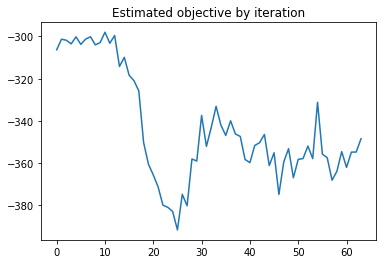

In [7]:
trace.plot_objectives()

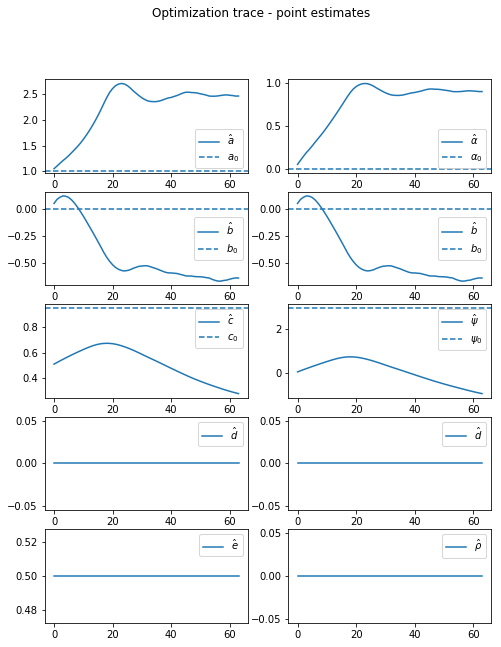

In [8]:
trace.plot(figsize=[8,10], true=params)

In [9]:
fit.summary(true=params)

,estimate,true
a,2.4629,1.00
b,-0.6440,0.00
c,0.2809,0.95
d,0.0000,NaN
e,0.5000,NaN
